In [56]:
# Combine Time-Dependence and SimpleDiff

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sympy import *
import matplotlib.pyplot as plt
init_printing(use_latex=true)
filename = "TestDataLots.xlsx"

In [57]:
# Establish symbols
n, T, i, t, lda, eps = symbols('n T i t \lambda \epsilon')       # n wells & T timepoints

In [58]:
# Establish number of wells
n = pd.read_excel(filename, sheet_name='n').iloc[0,0]
n

5

In [59]:
# Establish number of timepoints
T = pd.read_excel(filename, sheet_name='T').iloc[0,0]
T

41

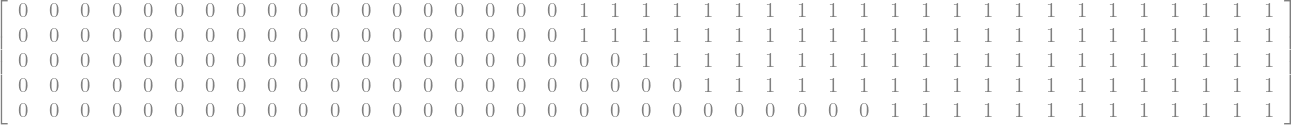

In [60]:
# Establish binary matrix for wells being on or off
z = MatrixSymbol('z', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(z.as_explicit())
zReal = Matrix(pd.read_excel(filename, sheet_name="OnOff").to_numpy().T)
zReal

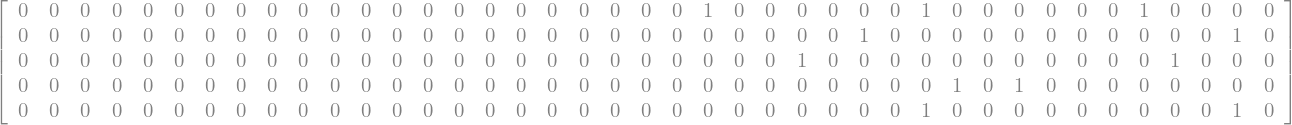

In [61]:
# Establish binary matrix for wells being measured or not
d = MatrixSymbol('d', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(d.as_explicit())
dReal = Matrix(pd.read_excel(filename, sheet_name="Measured").to_numpy().T)
dTotal = sum(dReal)
dReal

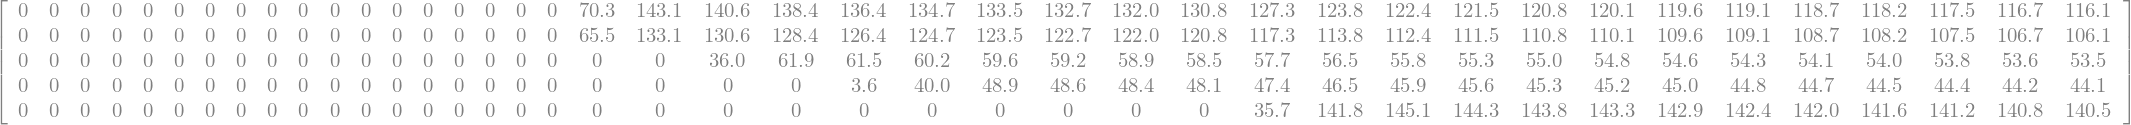

In [62]:
# Establish matrix of actual mass flows
m = MatrixSymbol('m', n, T)  
#pprint(m.as_explicit())
mReal = Matrix(pd.read_excel(filename, sheet_name="MassFlows").to_numpy().T)
mReal

In [63]:
# Establish matrix / vector of total mass flow
M = MatrixSymbol('M', 1, T)
#pprint(M.as_explicit())
MReal = Matrix(pd.read_excel(filename, sheet_name="TotalMassFlow").to_numpy().T)
MReal

In [64]:
# Establish solution vectors of initial mass flows and gradients per well 
wc = MatrixSymbol('wc', n, 1)
pprint(wc.as_explicit())
wg = MatrixSymbol('wg', n, 1)
pprint(wg.as_explicit())

# At any timepoint, w = wc + t*wg

⎡wc₀₀⎤
⎢    ⎥
⎢wc₁₀⎥
⎢    ⎥
⎢wc₂₀⎥
⎢    ⎥
⎢wc₃₀⎥
⎢    ⎥
⎣wc₄₀⎦
⎡wg₀₀⎤
⎢    ⎥
⎢wg₁₀⎥
⎢    ⎥
⎢wg₂₀⎥
⎢    ⎥
⎢wg₃₀⎥
⎢    ⎥
⎣wg₄₀⎦


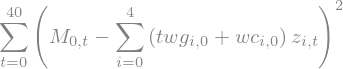

In [65]:
S1 = Sum((M[0,t] - Sum(z[i, t]*(wc[i,0]+t*wg[i,0]), (i, 0, n-1)))**2 , (t, 0, T-1))
S1

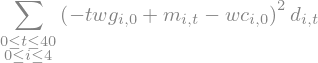

In [66]:
S2 = Sum(Sum(d[i,t]*((m[i,t]-(wc[i,0]+t*wg[i,0])))**2 , (t, 0, T-1)), (i, 0, n-1))
S2

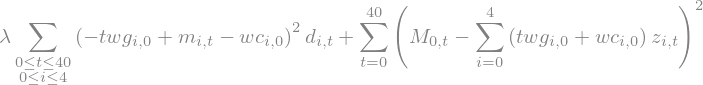

In [67]:
I = S1 + lda*S2
I

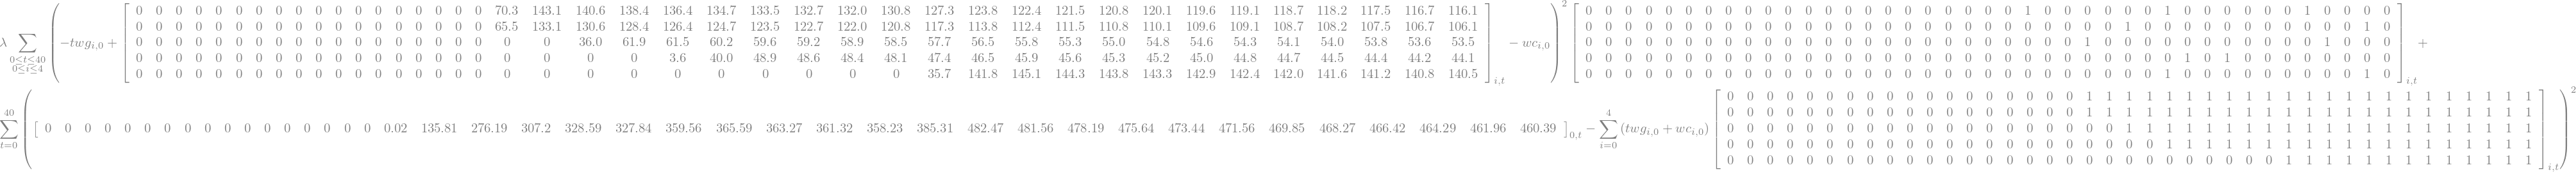

In [68]:
Inac = I.subs({M: MReal, z: zReal, d: dReal, m: mReal})
Inac

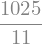

In [137]:
optLda = T*n**2/dTotal
Inaccuracy = Inac.subs(lda, optLda)
optLda

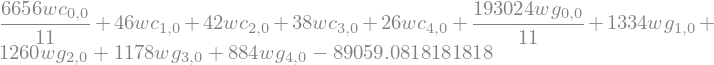

In [138]:
Inaccuracy.diff(wc[0,0]).doit()

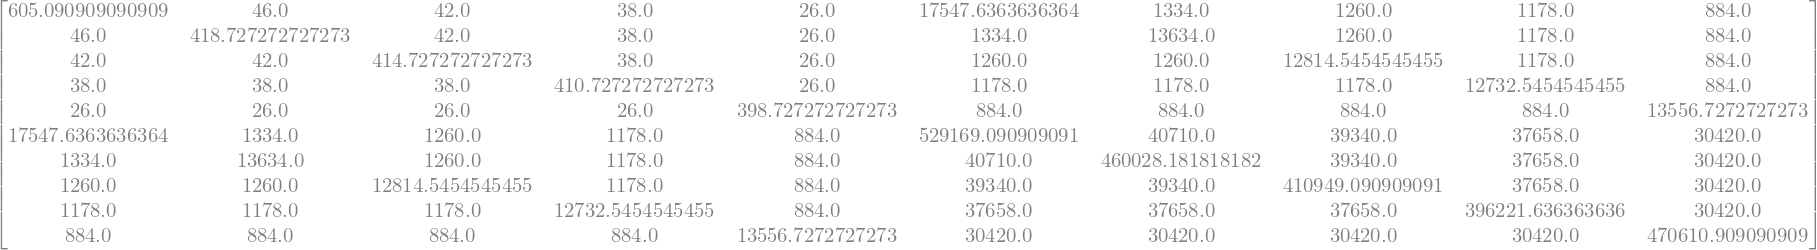

In [139]:
DiffA = np.zeros([2*n,2*n])
Diffb = np.zeros(2*n)
# Fill in matrix with values for Aw=b   (w = [wc; wg])
for i in range(n):
    Diffb[i] = -1*Poly(Inaccuracy.diff(wc[i,0]).doit()).coeffs()[-1]
    Diffb[n+i] = -1*Poly(Inaccuracy.diff(wg[i,0]).doit()).coeffs()[-1]
    for j in range(n):
        DiffA[i,j] = Inaccuracy.diff(wc[i,0]).doit().coeff(wc[j,0])
        DiffA[i+n,j] = Inaccuracy.diff(wg[i,0]).doit().coeff(wc[j,0])
        DiffA[i,j+n] = Inaccuracy.diff(wc[i,0]).doit().coeff(wg[j,0])
        DiffA[i+n,j+n] = Inaccuracy.diff(wg[i,0]).doit().coeff(wg[j,0])
# Then solve for w
DiffMatrixA = Matrix(DiffA)
DiffMatrixb = Matrix(Diffb)
DiffMatrixA

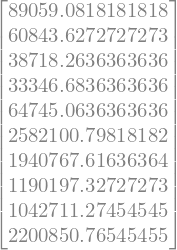

In [140]:
DiffMatrixb

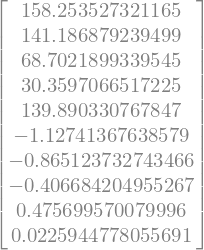

In [141]:
results = DiffMatrixA.inv()*DiffMatrixb
results

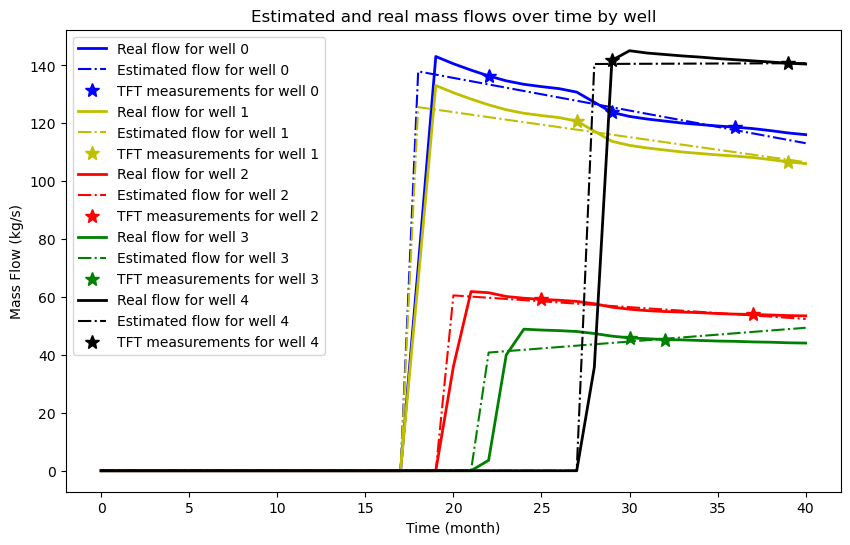

In [142]:
# Plot results from all wells
plt.figure(figsize=(10,6))
colours=['b', 'y', 'r', 'g', 'k']
for i in range(n):
    plt.plot(range(T),mReal[i,:][:], colours[i]+'-', lw=2, label="Real flow for well "+str(i))
    # Plot Time-Dependently
    toplot = []
    for t in range(T):
        resplot = (results[i]+t*results[i+n])
        toplot.append(resplot*zReal[i,t])
    plt.plot(range(T),toplot, colours[i]+'-.', lw=1.5, label="Estimated flow for well "+str(i))
    # Plot TFT points
    monthplot = []
    tftplot = []
    for month,element in enumerate(dReal[i,:]):
        if element==1:
            monthplot.append(month)
            tftplot.append(mReal[i,month])
    plt.plot(monthplot, tftplot, colours[i]+'*', markersize=10, label="TFT measurements for well "+str(i))
            
plt.title("Estimated and real mass flows over time by well")
plt.xlabel("Time (month)")
plt.ylabel("Mass Flow (kg/s)")
plt.legend()


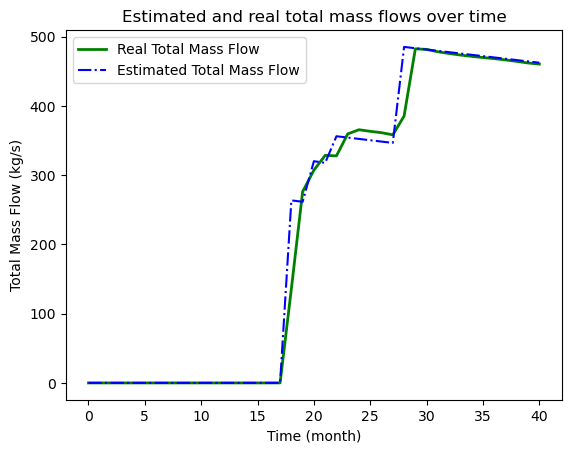

In [143]:
# Plot total flow vs found total flow
totalFlowFound = np.zeros((T,1))
times = range(T)
for t in range(T):
    tff = [(results[i]+t*results[i+n])*zReal[i,t] for i in range(n)]
    #print(t, tff)
    totalFlowFound[t] = sum(tff)

plt.plot(list(Matrix(times).T), list(MReal), 'g-', lw=2, label="Real Total Mass Flow")
plt.plot(times,totalFlowFound, 'b-.', lw=1.5, label="Estimated Total Mass Flow")

plt.title("Estimated and real total mass flows over time")
plt.xlabel("Time (month)")
plt.ylabel("Total Mass Flow (kg/s)")
plt.legend()